In [127]:
import sys
#!{sys.executable} -m pip uninstall rasterio
#!{sys.executable} -m pip install --pre -U rasterio
#!{sys.executable} -m pip install affine
#!{sys.executable} -m pip install fiona
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install mplleaflet

In [2]:
#import sys
import os
import json
import scipy
#import urllib
#import datetime 
#import urllib3
import rasterio
from affine import Affine
import fiona
#import subprocess
import numpy as np
import pandas as pd
#import seaborn as sns
from osgeo import gdal
#from planet import api
#from planet.api import filters
#from traitlets import link
#import rasterio.tools.mask as rio_mask
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform

In [3]:
planet_tif = "./etpi/20190506_235522_1018_3B_AnalyticMS.tif"

In [4]:
with rasterio.open(planet_tif) as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)

9048 4484
+init=epsg:32755
| 3.00, 0.00, 599670.00|
| 0.00,-3.00, 7237089.00|
| 0.00, 0.00, 1.00|
4
(1, 2, 3, 4)


In [5]:
# FRom: https://github.com/kscottz/PythonFromSpace/blob/master/TheBasics.ipynb
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])

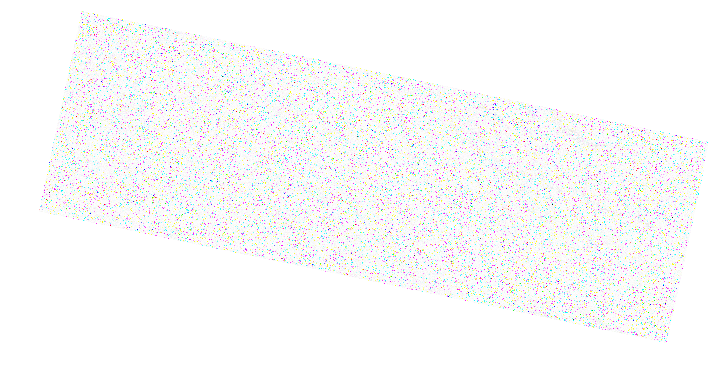

In [6]:
fb = load_image4(planet_tif)
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(fb)
plt.show()

In [7]:
with open('./etpi/20190506_235522_1018_metadata.json') as data_file:    
    geoms= json.load(data_file)
print(geoms)

{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20190506_235522_1018', 'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20190506_235522_1018/assets/', 'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20190506_235522_1018/thumb'}, '_permissions': ['assets.basic_analytic_rpc_nitf:download', 'assets.udm2:download', 'assets.analytic_xml:download', 'assets.basic_analytic_dn:download', 'assets.basic_analytic_dn_xml_nitf:download', 'assets.basic_analytic_dn_nitf:download', 'assets.basic_analytic_xml:download', 'assets.basic_analytic_nitf:download', 'assets.basic_analytic_rpc:download', 'assets.analytic_dn:download', 'assets.basic_udm:download', 'assets.basic_analytic_dn_rpc_nitf:download', 'assets.analytic:download', 'assets.analytic_dn_xml:download', 'assets.analytic_sr:download', 'assets.basic_analytic_dn_xml:download', 'assets.basic_udm2:download', 'assets.basic_analytic_dn_rpc:download', 'assets.basic_an

In [8]:
g = geoms.get('geometry')
print(g)

{'coordinates': [[[147.99045264412132, -25.04103302278979], [148.00458570344102, -24.978198114818447], [148.2568220562747, -25.02411839582666], [148.2545388188982, -25.03429960381565], [148.25490136670885, -25.03436600176885], [148.25266986301122, -25.044464888218624], [148.24051662644368, -25.097904597363776], [147.98812549355154, -25.051701831078848], [147.99045264412132, -25.04103302278979]]], 'type': 'Polygon'}


In [9]:
with fiona.open('./etpi/20190506_235522_1018_metadata.json', "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
    
print(geoms)

[{'type': 'Polygon', 'coordinates': [[(147.99045264412132, -25.04103302278979), (148.00458570344102, -24.978198114818447), (148.2568220562747, -25.02411839582666), (148.2545388188982, -25.03429960381565), (148.25490136670885, -25.03436600176885), (148.25266986301122, -25.044464888218624), (148.24051662644368, -25.097904597363776), (147.98812549355154, -25.051701831078848), (147.99045264412132, -25.04103302278979)]]}]


In [10]:
fb.shape

(4484, 9048, 4)

In [11]:
rs = transform.rescale(fb, 5/10) # this is skimage.transform
rs.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(2242, 4524, 4)

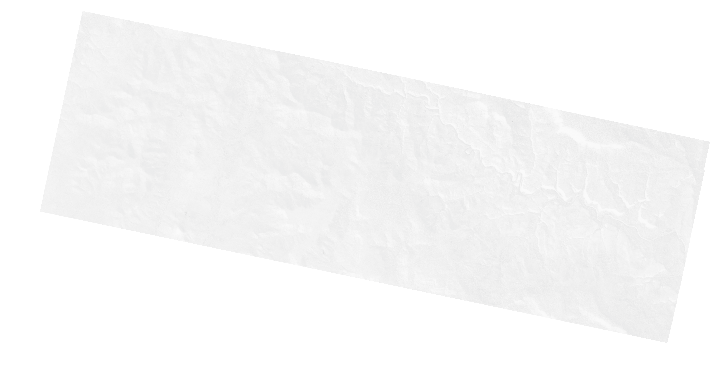

In [12]:
#rs = transform.rescale(fb, 5/10) # this is skimage.transform
#rs.shape
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(rs)
plt.show()

In [13]:
# planet bands:
# b
# g
# r
# nir
#Blue Green Red NIR
#455 – 515 nm 500 – 590 nm 590 – 670 nm 780 – 860 nm
# R672/(R550×R708) 
# A function to calculate ECARR index, substituting LS8 Band 3 for Modis Band 1:
def calc_ecarr_using_band1_reflectance(data_ecarr,coef):
    #data_ecarr = img.read([3,2]).astype(np.float32)
    nir = data_ecarr[:,:,3] * coef[4] #4.25585456224e-05 # 3 Red
    red = data_ecarr[:,:,2] * coef[3] #2.85577526769e-05 # 2 Green
    green = data_ecarr[:,:,1] * coef[2]
    
    #ecarr = 0.0161 * ((red / (green * nir) ) ** 0.7784)
    ecarr = 0.0161 * ((red / (green * red) ) ** 0.7784)
    return(ecarr)


from xml.dom import minidom


def getReflectanceCoeffs(xmlmetaf):
    xmldoc = minidom.parse(xmlmetaf)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
            
    return(coeffs)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


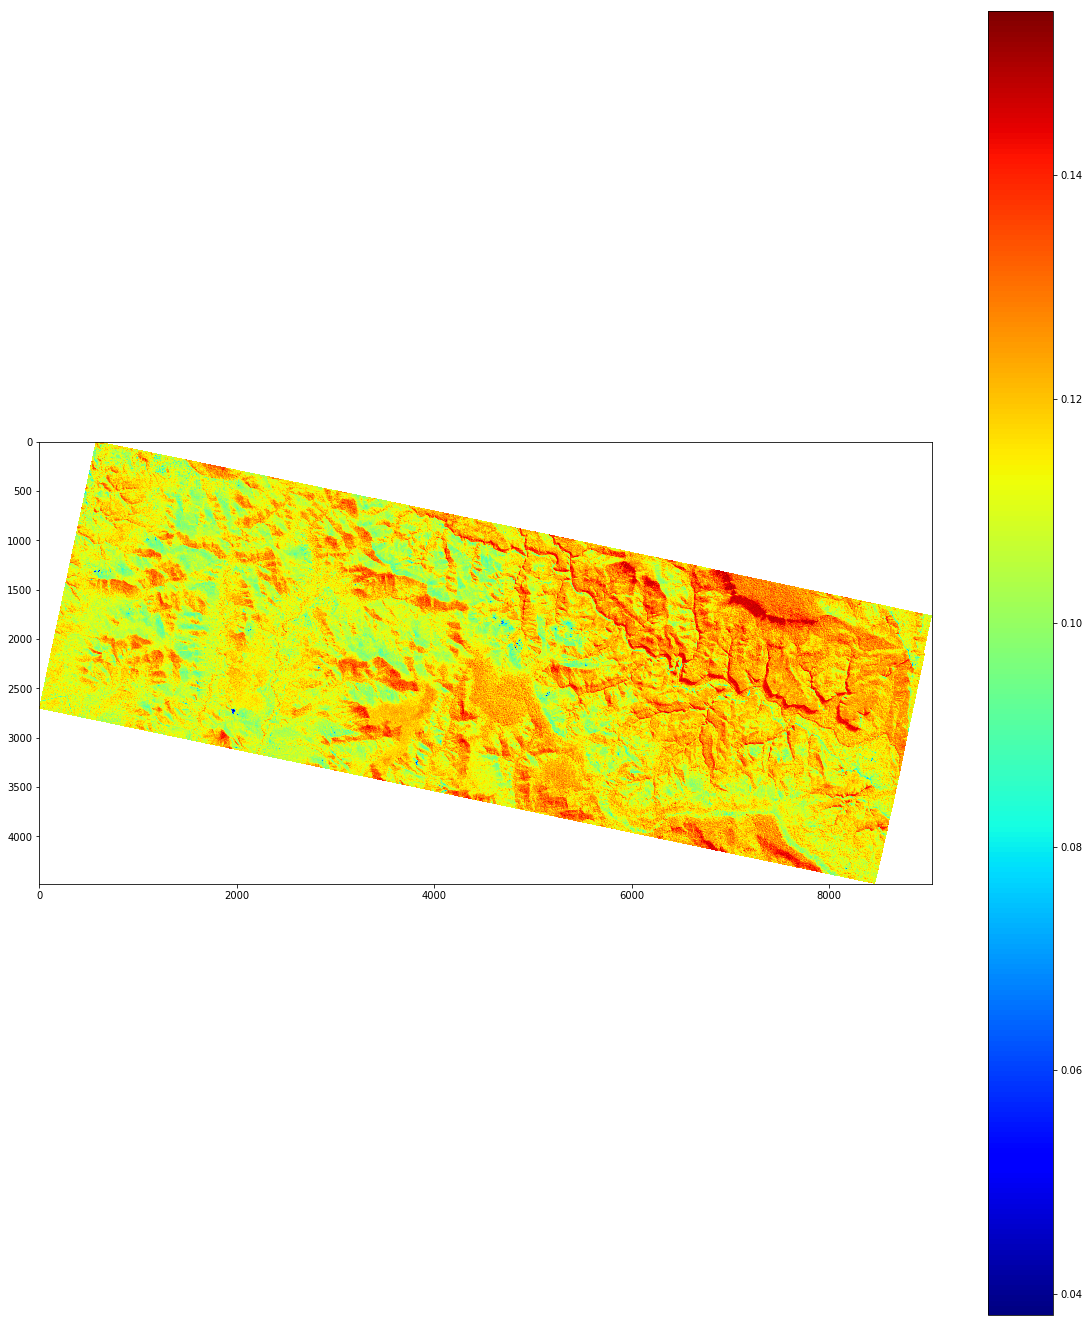

In [14]:

coeffs = getReflectanceCoeffs("./etpi/20190506_235522_1018_3B_AnalyticMS_metadata.xml")

f, ax = plt.subplots(1, figsize=(20,24))
t = calc_ecarr_using_band1_reflectance(fb,coeffs)
#t = calc_nvdi(fb)
plt.set_cmap('jet')
plt.imshow(t)
plt.colorbar()
plt.show()

In [15]:

def calc_ecarr_using_band1_reflectance_nir(data_ecarr,coef):
    #data_ecarr = img.read([3,2]).astype(np.float32)
    nir = data_ecarr[:,:,3] * coef[4] #4.25585456224e-05 # 3 Red
    red = data_ecarr[:,:,2] * coef[3] #2.85577526769e-05 # 2 Green
    green = data_ecarr[:,:,1] * coef[2]
    
    ecarr = 0.0161 * ((red / (green * nir) ) ** 0.7784)
    #ecarr = 0.0161 * ((red / (green * red) ) ** 0.7784)
    return(ecarr)


def calc_ecarr2_using_band1_reflectance_nir(data_ecarr,coef):
    #data_ecarr = img.read([3,2]).astype(np.float32)
    nir = data_ecarr[:,:,3] * coef[4] #4.25585456224e-05 # 3 Red
    red = data_ecarr[:,:,2] * coef[3] #2.85577526769e-05 # 2 Green
    green = data_ecarr[:,:,1] * coef[2]
    
    ecarr2 = 0.0008 * ( nir/(green*red)) ** 1.2403
    return(ecarr2)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


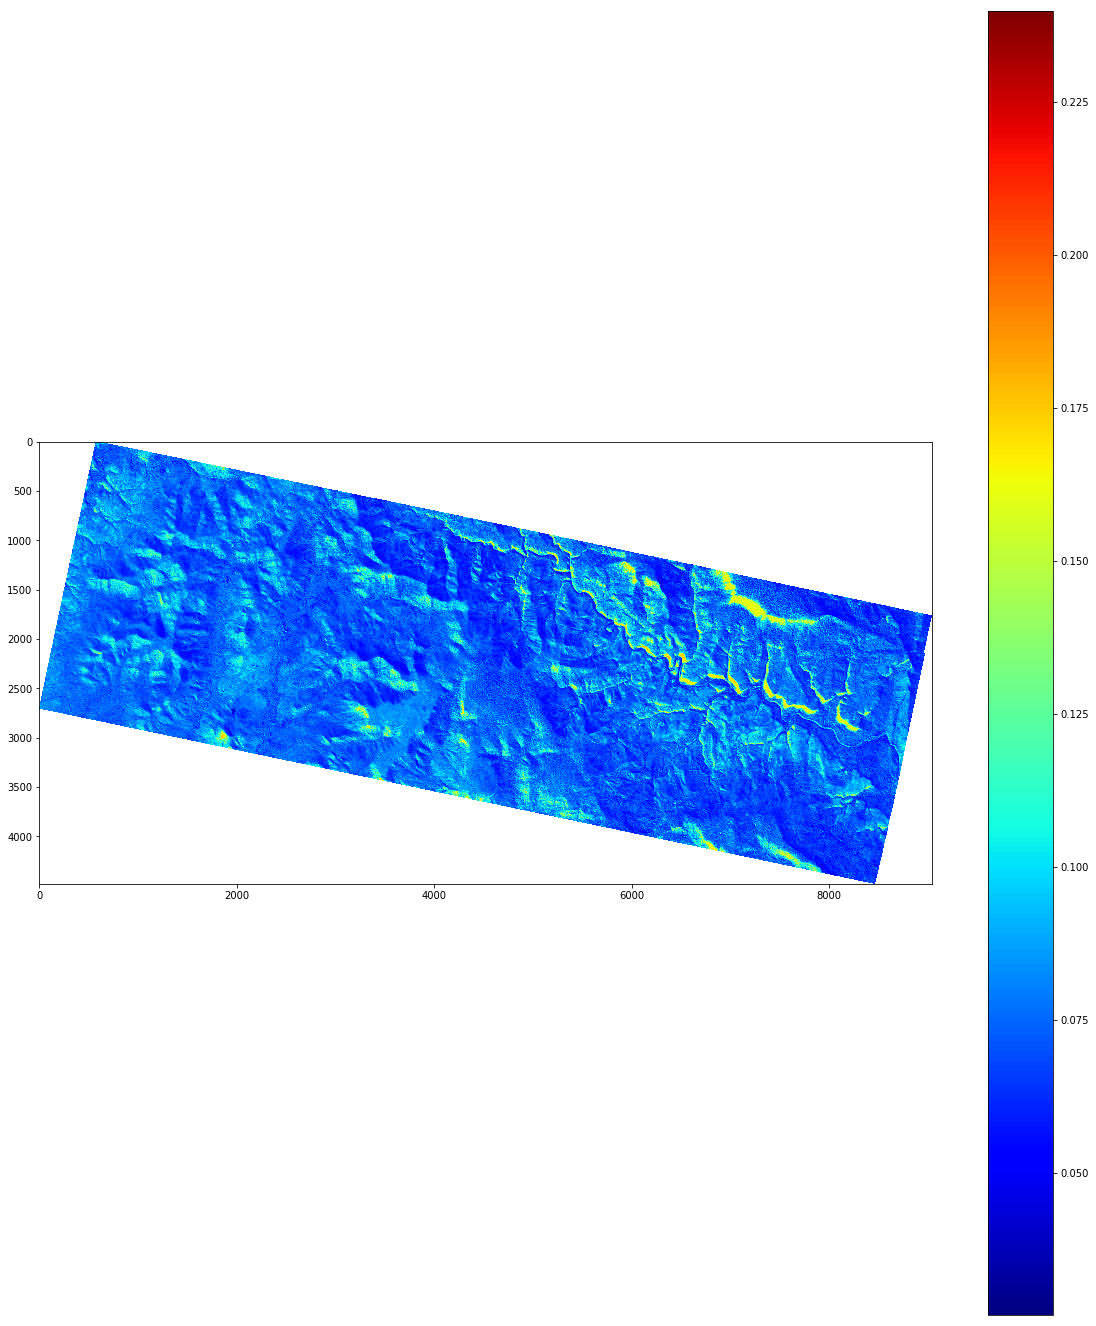

In [16]:
f, ax = plt.subplots(1, figsize=(20,24))
t = calc_ecarr_using_band1_reflectance_nir(fb,coeffs)
#t = calc_nvdi(fb)
plt.set_cmap('jet')
plt.imshow(t)
plt.colorbar()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


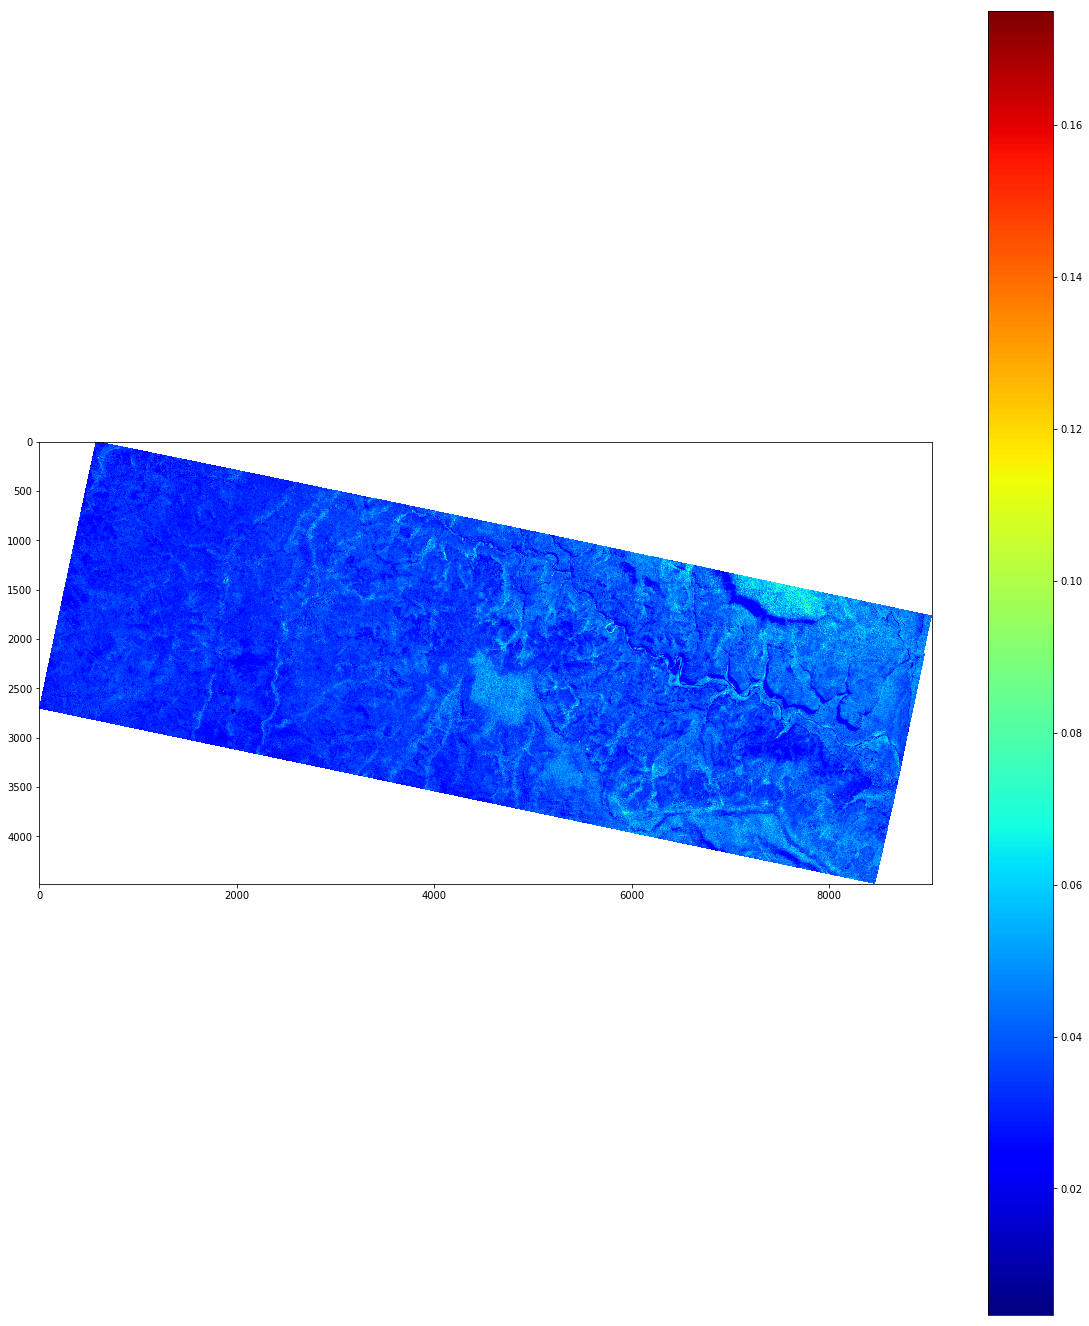

In [17]:

f, ax = plt.subplots(1, figsize=(20,24))
t = calc_ecarr2_using_band1_reflectance_nir(fb,coeffs)
#t = calc_nvdi(fb)
plt.set_cmap('jet')
plt.imshow(t)
plt.colorbar()
plt.show()